In [21]:
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

import cv2
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines,
    group_lines, crop_image_by_points, transform_line)
from src.utils.plotting import display_img
from src.utils.playfield_finder import PlayfieldFinder
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'gray'

In [22]:
pic = read_image_as_numpyimage('/home/polymorvic/development/deep-peep-snooker/pics/runda_8/pic_08_08_01.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png # runda_8/pic_08_08_01.png'
cropped_pic = crop_center(pic)

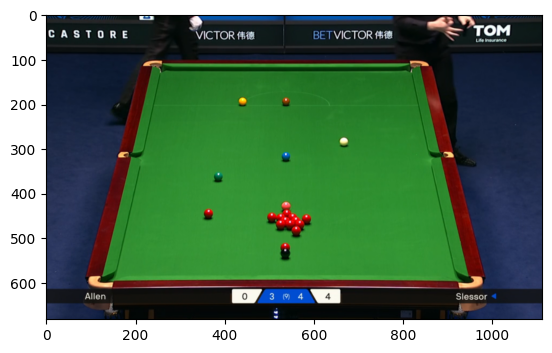

In [23]:
plt.imshow(pic)

In [24]:
finder = PlayfieldFinder(pic)

In [25]:
cushions = finder.find_side_cushions()

In [26]:
# img = cushions['top_left'][0]

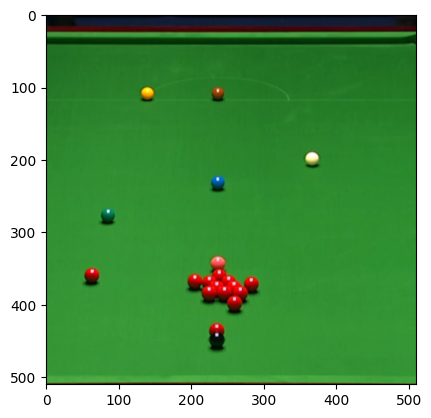

In [27]:
plt.imshow(cropped_pic)

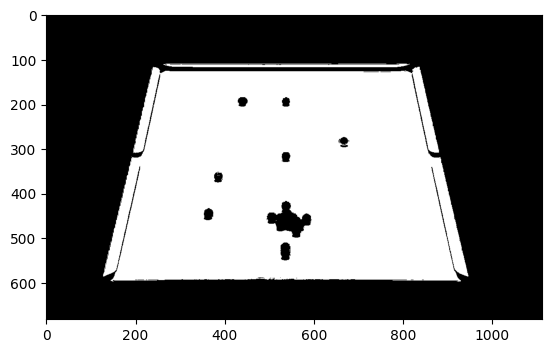

In [28]:
pic_hsv = cv2.cvtColor(pic, cv2.COLOR_RGB2HSV)
cropped_pic_hsv = cv2.cvtColor(cropped_pic, cv2.COLOR_RGB2HSV)

dominant_color = pipette_color(cropped_pic_hsv)

h, s, v = dominant_color
h_std = np.std(cropped_pic_hsv[:, :, 0])
s_std = np.std(cropped_pic_hsv[:, :, 1])
v_std = np.std(cropped_pic_hsv[:, :, 2])

h_tolerance = int(h_std * 1.5)
s_tolerance = int(s_std * 1.5)
v_tolerance = int(v_std * 1.5)

lower_bound = np.array([max(0, h - h_tolerance), 
                       max(0, s - s_tolerance), 
                       max(0, v - v_tolerance)])

upper_bound = np.array([min(179, h + h_tolerance), 
                       min(255, s + s_tolerance), 
                       min(255, v + v_tolerance)])

binary_mask = cv2.inRange(pic_hsv, lower_bound, upper_bound)

plt.imshow(binary_mask)
plt.show()

In [29]:
inv_binary_img = cv2.bitwise_not(binary_mask)

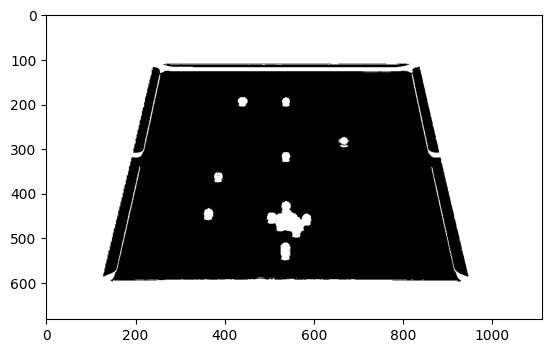

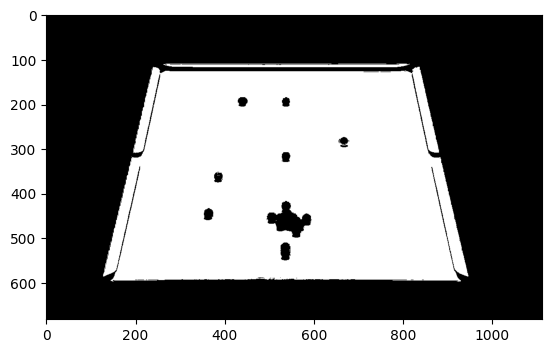

In [30]:
plt.imshow(inv_binary_img)
plt.show()
plt.imshow(binary_mask)

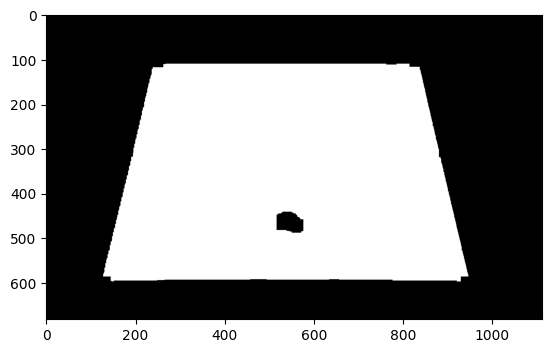

In [31]:
binary_mask_close = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((21, 21), np.uint8))
plt.imshow(binary_mask_close)

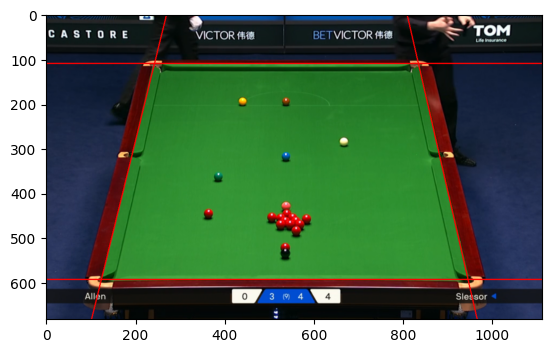

In [32]:
edges = cv2.Canny(binary_mask_close, 150, 200)

segments = cv2.HoughLinesP(
    edges, 
    1, 
    np.pi / 180, 
    threshold=100, 
    minLineLength=100, 
    maxLineGap=10
)

lines = _convert_hough_segments_to_lines(segments)
lines = group_lines(lines, thresh_theta=5, thresh_intercept=100)

pic_copy = pic.copy()
for line in lines:
    pts = line.limit_to_img(pic_copy)
    cv2.line(pic_copy, *pts, (255, 0, 0), 2)

plt.imshow(pic_copy)

In [33]:
intersections = set()
for group1 in lines:
    for group2 in lines:
        intersection = group1.intersection(group2, pic_copy)
        if intersection is not None:
            intersections.add(intersection)
            
intersections = list(intersections)
intersection_points = np.array([[int(inter.point.x), int(inter.point.y)] for inter in intersections])

In [34]:
intersection_points

array([[124, 593],
       [946, 593],
       [243, 110],
       [834, 110]])

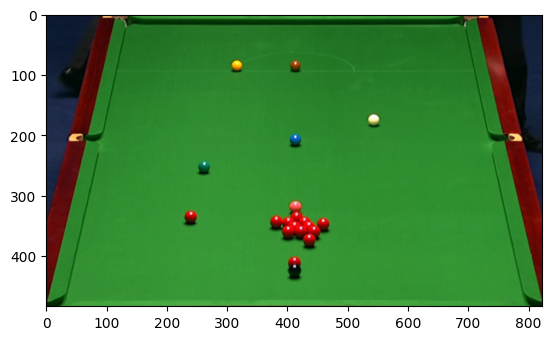

(124, 110)

In [35]:
cropped_by_points, x_start, y_start = crop_image_by_points(pic, intersection_points)
display_img(cropped_by_points)
x_start, y_start 

In [36]:
hsv_img = cv2.cvtColor(cropped_by_points, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_img)

In [ ]:
# wzmocnienie kontrastu
# v_eq = cv2.equalizeHist(v) # wyrownywanie histogramu

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
v_eq = clahe.apply(v)

In [38]:
v_eq

array([[76, 76, 76, ..., 75, 75, 75],
       [76, 76, 76, ..., 75, 75, 75],
       [76, 76, 76, ..., 78, 75, 75],
       ...,
       [15, 21, 29, ..., 30, 32, 34],
       [18, 23, 29, ..., 26, 28, 33],
       [18, 23, 26, ..., 25, 26, 32]], shape=(484, 823), dtype=uint8)

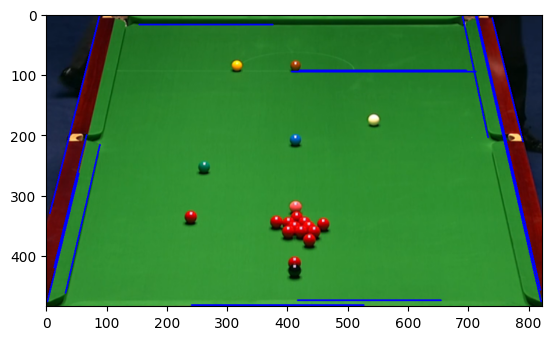

In [39]:
edges = cv2.Canny(v_eq, 50, 150)

lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi/180,
    threshold=100,
    minLineLength=200,
    maxLineGap=10
)

pic_copy2 = cropped_by_points.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(pic_copy2, (x1, y1), (x2, y2), (0, 0, 255), 2)
plt.imshow(pic_copy2)

LineGroup: y = 0.00 * x + 1.00 (from 1 lines)
LineGroup: y = 0.00 * x + 94.00 (from 2 lines)
LineGroup: y = 0.00 * x + 17.00 (from 1 lines)
LineGroup: y = 0.00 * x + 478.00 (from 2 lines)


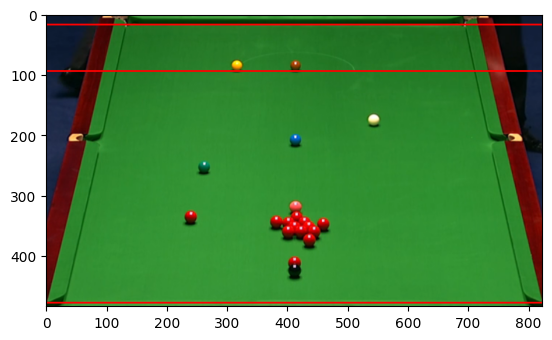

In [40]:
lines = _convert_hough_segments_to_lines(lines)
lines = [line for line in lines if abs(line.slope) < 2]
lines = group_lines(lines, thresh_theta=50, thresh_intercept=10)

pic_copy2 = cropped_by_points.copy()
for line in lines:
    print(line)
    pts = line.limit_to_img(pic_copy2)
    cv2.line(pic_copy2, *pts, (255, 0, 0), 2)

plt.imshow(pic_copy2)

lines = sorted(lines, key=lambda line: line.intercept)

# Wybierz linię z interceptem najbliższym środkowi obrazu
center_y = cropped_by_points.height / 2
baulk_line_local = min(lines, key=lambda line: abs(line.intercept - center_y))

In [41]:
baulk_line_local

LineGroup: y = 0.00 * x + 94.00 (from 2 lines)

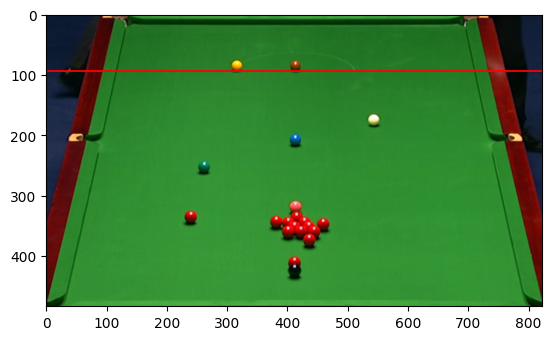

In [42]:
crop_copy = cropped_by_points.copy()
pts = baulk_line_local.limit_to_img(crop_copy)
cv2.line(crop_copy, *pts, (255, 0, 0), 2)
plt.imshow(crop_copy)

In [43]:
baulk_line_global = transform_line(baulk_line_local, pic, x_start, y_start)
baulk_line_global

y = 0.0 * x + 204.0

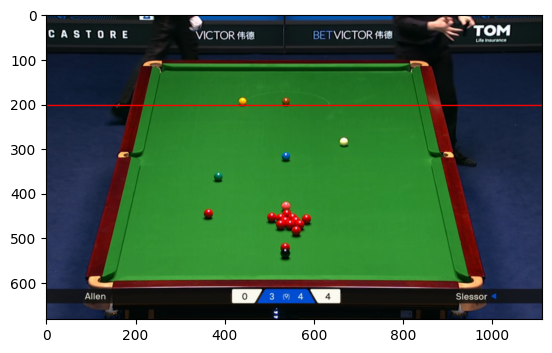

In [44]:
or_img = pic.copy()
pts = baulk_line_global.limit_to_img(or_img)
cv2.line(or_img, *pts, (255, 0, 0), 2)
plt.imshow(or_img)